In [2]:
# import des modules nécessaires
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.patches as mpatches
from distinctipy import distinctipy
from matplotlib.font_manager import FontProperties
from matplotlib import rc
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import clear_output, display
from scipy.stats import chi2_contingency as chi2_contingency
import statsmodels.formula.api as statsapi
import statsmodels as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import xlrd as xlrd
from matplotlib import font_manager # for mac users
import platform
import os
from sklearn.decomposition import PCA

# Modifier les paramètres d'affichage de la sortie des commandes dans Jupyter
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

# Pour lister les polices présentes
#fpaths = matplotlib.font_manager.findSystemFonts()
#for i in fpaths:
#    f = matplotlib.font_manager.get_font(i)
#    print(f.family_name)
# import de la police Garamond

system = platform.system()
print(system)
if system == 'Darwin':  # macOS
  font_path = '/Library/Fonts/GaramondPremrPro.otf'
elif system == 'Windows':
  font_path = 'C:/Windows/Fonts/Garamond.TTF'
else:  #  unix
  font_path = 'GARA.TTF'
print(font_path)

garamond_font = FontProperties(fname="/Library/Fonts/GaramondPremrPro.otf",size=14) # for MAC
garamond_font = FontProperties(fname="/Library/Fonts/Garamond.otf",size=14) # for WINDOWS

#    timesnewroman_font = FontProperties(fname="C:/Windows/Fonts/TIMES.TTF",size=14)

font_manager.findSystemFonts(fontpaths=font_path, fontext="ttf")
font_manager.findfont("Garamond Premier Pro") 

# Définissez la police par défaut pour toute la figure
matplotlib.rcParams['font.family'] = 'Garamond'

findfont: Font family ['Garamond Premier Pro'] not found. Falling back to DejaVu Sans.


Windows
C:/Windows/Fonts/Garamond.TTF


In [3]:
# Chargement des données CANCER DU SEIN
df_bc_data = pd.read_table("input/mlsupervise/wdbc.data",sep=",")
#df_bc_names = pd.read_table("input/mlsupervise/wdbc.names",sep=",")

# Ajout titre colonnes
df_bc_data.columns=["ID",
                    "diagnosis",
                    "radius_mean",
                    "texture_mean",
                    "flipper_length_mm",
                    "smoothness_mean",
                    "compactness_mean",
                    "concavity_mean",
                    "concave_points_mean",
                    "symmetry",
                    "fractal_dimension_mean",
                    "12","13","14","15","16","17","18","19","20",
                    "21","22","23","24","25","26","27","28","29","30","31","32"]
print(df_bc_data.iloc[0:5,0:10])
# Verif données
#print("Cols: ",df_bc_data.columns)
#print(df_bc_data.isna().count())
print(type(df_bc_data))
print(df_bc_data.shape)

# ==> Pas de valeurs manquantes

         ID diagnosis  radius_mean  texture_mean  flipper_length_mm  smoothness_mean  \
0    842517         M        20.57         17.77             132.90           1326.0   
1  84300903         M        19.69         21.25             130.00           1203.0   
2  84348301         M        11.42         20.38              77.58            386.1   
3  84358402         M        20.29         14.34             135.10           1297.0   
4    843786         M        12.45         15.70              82.57            477.1   

   compactness_mean  concavity_mean  concave_points_mean  symmetry  
0           0.08474         0.07864               0.0869   0.07017  
1           0.10960         0.15990               0.1974   0.12790  
2           0.14250         0.28390               0.2414   0.10520  
3           0.10030         0.13280               0.1980   0.10430  
4           0.12780         0.17000               0.1578   0.08089  
<class 'pandas.core.frame.DataFrame'>
(568, 32)


Projet 2. Le cancer du sein

In [4]:
# Projet 2. Question 1

# import des librairies
from sklearn.model_selection import train_test_split
y=pd.DataFrame()
y["diagnosis"]=df_bc_data["diagnosis"]
print("y :\n", y.head(5))
X=df_bc_data.drop(columns={"diagnosis"})
print("X:\n",X.iloc[:,0:9].head(5))


# Split du jeu de données
X_train_temp, X_test_temp, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, shuffle=False, stratify=None)

print("X_train_temp ", X_train_temp.shape)
print("X_test_temp ", X_test_temp.shape)

y :
   diagnosis
0         M
1         M
2         M
3         M
4         M
X:
          ID  radius_mean  texture_mean  flipper_length_mm  smoothness_mean  compactness_mean  \
0    842517        20.57         17.77             132.90           1326.0           0.08474   
1  84300903        19.69         21.25             130.00           1203.0           0.10960   
2  84348301        11.42         20.38              77.58            386.1           0.14250   
3  84358402        20.29         14.34             135.10           1297.0           0.10030   
4    843786        12.45         15.70              82.57            477.1           0.12780   

   concavity_mean  concave_points_mean  symmetry  
0         0.07864               0.0869   0.07017  
1         0.15990               0.1974   0.12790  
2         0.28390               0.2414   0.10520  
3         0.13280               0.1980   0.10430  
4         0.17000               0.1578   0.08089  
X_train_temp  (454, 31)
X_test_temp 

In [5]:
# Remplacement des valeurs de y_train par 1 ou 0
y_train.replace({"M": 1, "B": 0},inplace=True)

# Remplacement des valeurs de y_test par 1 ou 0
y_test.replace({"M": 1, "B": 0},inplace=True)

# Extraction des 2 features radius_mean et concavepoints_mean pour train
radius_mean_train = X_train_temp.iloc[:,2]
concave_points_mean_train = X_train_temp.iloc[:,7]
X_train = pd.concat([radius_mean_train,concave_points_mean_train],axis=1, ignore_index=True) # Reforme X_train avec les 2 colonnes
print(X_train.head(5))

# Extraction des 2 features radius_mean et concavepoints_mean pour test
radius_mean_test = X_test_temp.iloc[:,2]
concave_points_mean_test = X_test_temp.iloc[:,7]
X_test = pd.concat([radius_mean_test,concave_points_mean_test],axis=1, ignore_index=True) # Reforme X_test avec les 2 colonnes
print(X_test.head(5))

print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

       0       1
0  17.77  0.0869
1  21.25  0.1974
2  20.38  0.2414
3  14.34  0.1980
4  15.70  0.1578
         0        1
454  30.72  0.02819
455  29.29  0.07160
456  25.25  0.02772
457  25.13  0.01206
458  28.20  0.01541
X_train  (454, 2)
X_test  (114, 2)
y_train  (454, 1)
y_test  (114, 1)


In [7]:
import sklearn
from sklearn import tree
#from sklearn.tree import tree
from sklearn.tree import DecisionTreeClassifier

# Entrainement d'un modèle de Classifier et de X_train, y_train

dt = DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=6)
dt = dt.fit(X_train,y_train)

# Prédiction à l'aide du modèle et de X_test et y_test

y_pred=dt.predict(X_test)
print("Prédiction:\n",y_pred[0:10]) # affichage de la prediction
print("y_test:\n", y_test.iloc[0:10]) # affichage de la réalité y_test pour comparaison avec la prediction

Prédiction:
 [0 1 0 0 0 1 1 0 0 0]
y_test:
      diagnosis
454          0
455          0
456          0
457          0
458          0
459          1
460          1
461          0
462          0
463          0


['radius_mean', 'concave_points_mean']
['B', 'M']


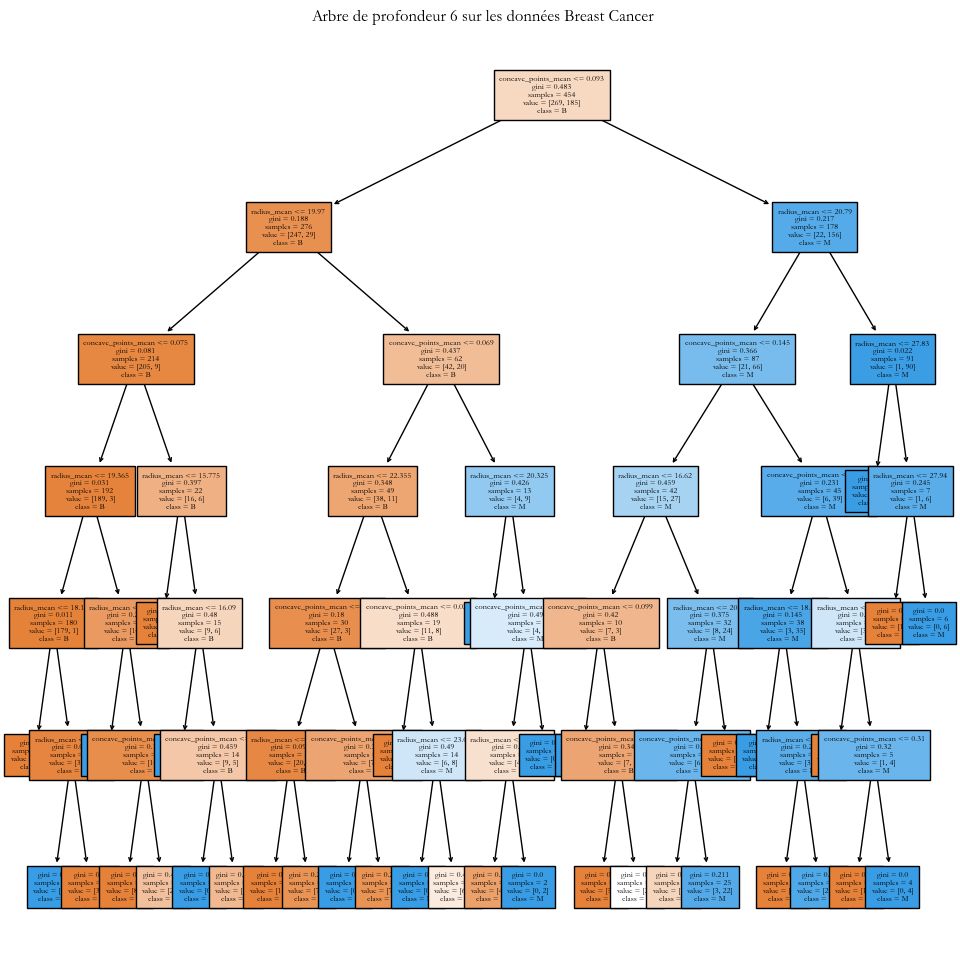

In [8]:
# Verification des données
feature_names=["radius_mean","concave_points_mean"]
class_names=["B","M"]
print(feature_names)
print(class_names)

# Affichage de l'Arbre
fig = plt.figure(figsize=(12,12))
tree.plot_tree(dt,filled=True, feature_names=feature_names,class_names=class_names,fontsize=6)
plt.title("Arbre de profondeur 6 sur les données Breast Cancer")
plt.show()

<H3>Projet 2. Exercice 2. Point 1. </H3>

In [9]:
from sklearn.metrics import accuracy_score
print(y_test)


     diagnosis
454          0
455          0
456          0
457          0
458          0
..         ...
563          1
564          1
565          1
566          1
567          0

[114 rows x 1 columns]


<H3>Projet 2. Exercice 2. Point 2. </H3>

In [10]:
y_pred = y_pred


<H3>Projet 2. Exercice 2. Point 3. </H3>

In [11]:
m_perf = accuracy_score(y_test, y_pred)
m_perf = round(m_perf,2)
print(100*m_perf,"%")

89.0 %


<H3> Projet 2. Exercice 2. Point 4 </H3>

In [12]:
# Projet 2. Exercice 2. Question 4

y=pd.DataFrame()
y["diagnosis"]=df_bc_data["diagnosis"].copy()
X=df_bc_data.drop(columns={"diagnosis"}) # Utilisation de toutes les features du jeu de données sauf le résultat


# Split du jeu de données
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, shuffle=False, stratify=None)

print("X_train", X_train_temp.shape)
print("X_test", X_test_temp.shape)

X_train (454, 31)
X_test (114, 31)


In [13]:
# Remplacement des valeurs de y_train par 1 ou 0
y_train.replace({"M": 1, "B": 0},inplace=True)

# Remplacement des valeurs de y_test par 1 ou 0
y_test.replace({"M": 1, "B": 0},inplace=True)

print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

X_train  (454, 31)
X_test  (114, 31)
y_train  (454, 1)
y_test  (114, 1)


<H3> Projet 2. Exercice 2. Point 6 </H3>

In [14]:
feature_names=["ID",
                    "diagnosis",
                    "radius_mean",
                    "texture_mean",
                    "flipper_length_mm",
                    "smoothness_mean",
                    "compactness_mean",
                    "concavity_mean",
                    "concave_points_mean",
                    "symmetry",
                    "fractal_dimension_mean",
                    "12","13","14","15","16","17","18","19","20",
                    "21","22","23","24","25","26","27","28","29","30","31","32"]

Prédiction:
 [0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 0]
y_test:
      diagnosis
454          0
455          0
456          0
457          0
458          0
..         ...
563          1
564          1
565          1
566          1
567          0

[114 rows x 1 columns]
['ID', 'diagnosis', 'radius_mean', 'texture_mean', 'flipper_length_mm', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry', 'fractal_dimension_mean', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
['B', 'M']


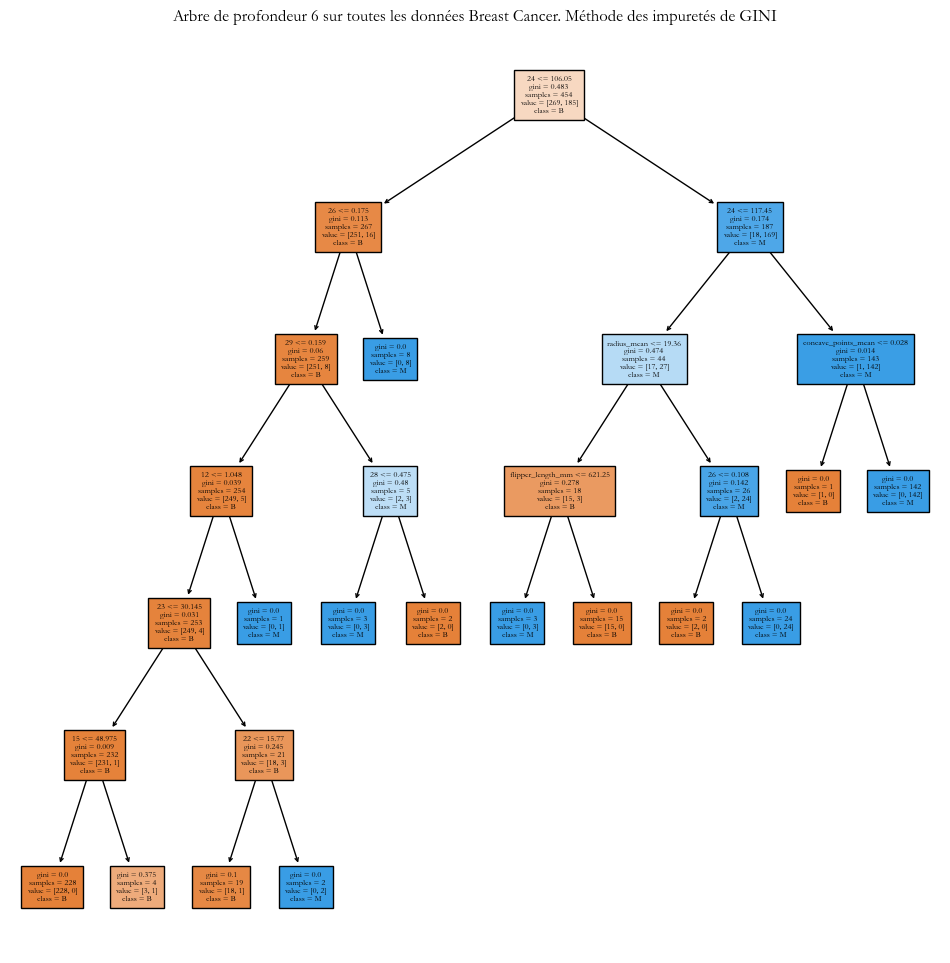

     diagnosis
454          0
455          0
456          0
457          0
458          0
..         ...
563          1
564          1
565          1
566          1
567          0

[114 rows x 1 columns]
89.0 %


In [28]:
# Entrainement d'un modèle de Classifier avec la méthode des impuretés de GINI

dt = DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=6)
dt = dt.fit(X_train,y_train)

# Prédiction à l'aide du modèle et de X_test et y_test

y_pred_GINI=dt.predict(X_test)
print("Prédiction:\n",y_pred_GINI) # affichage de la prediction
print("y_test:\n", y_test) # affichage de la réalité y_test pour comparaison avec la prediction

# Verification des données
class_names=["B","M"]
print(feature_names)
print(class_names)

# Affichage de l'Arbre
fig = plt.figure(figsize=(12,12))
tree.plot_tree(dt,filled=True, feature_names=feature_names,class_names=class_names,fontsize=6)
plt.title("Arbre de profondeur 6 sur toutes les données Breast Cancer. Méthode des impuretés de GINI")
plt.show()

from sklearn.metrics import accuracy_score
print(y_test)
m_perf = accuracy_score(y_test, y_pred_GINI)
m_perf = round(m_perf,2)
print(100*m_perf,"%")

Prédiction:
 [0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1
 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 0]
y_test:
      diagnosis
454          0
455          0
456          0
457          0
458          0
..         ...
563          1
564          1
565          1
566          1
567          0

[114 rows x 1 columns]
['ID', 'diagnosis', 'radius_mean', 'texture_mean', 'flipper_length_mm', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry', 'fractal_dimension_mean', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
['B', 'M']


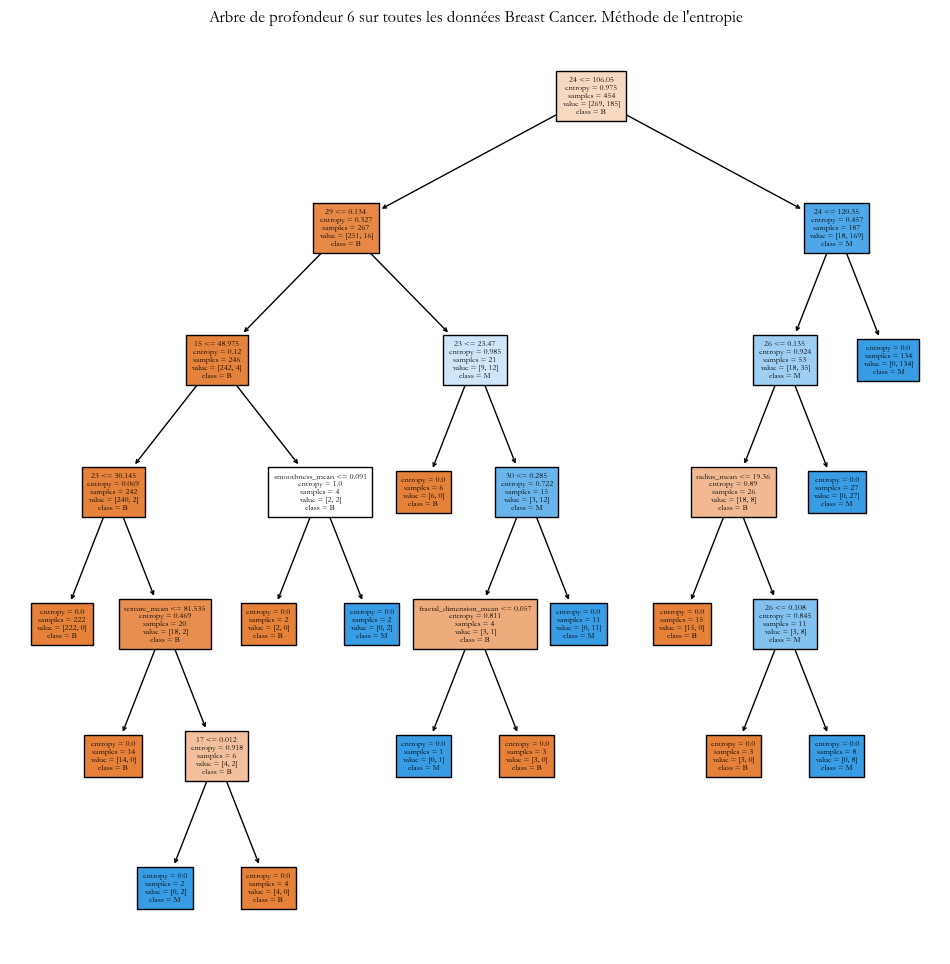

     diagnosis
454          0
455          0
456          0
457          0
458          0
..         ...
563          1
564          1
565          1
566          1
567          0

[114 rows x 1 columns]
90.0 %


In [27]:
# Entrainement d'un modèle de Classifier avec la méthode de l'Entropie

dt = DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=6)
dt = dt.fit(X_train,y_train)

# Prédiction à l'aide du modèle et de X_test et y_test

y_pred_Entropy=dt.predict(X_test)
print("Prédiction:\n",y_pred_Entropy) # affichage de la prediction
print("y_test:\n", y_test) # affichage de la réalité y_test pour comparaison avec la prediction

# Verification des données
class_names=["B","M"]
print(feature_names)
print(class_names)

# Affichage de l'Arbre
fig = plt.figure(figsize=(12,12))
tree.plot_tree(dt,filled=True, feature_names=feature_names,class_names=class_names,fontsize=6)
plt.title("Arbre de profondeur 6 sur toutes les données Breast Cancer. Méthode de l'entropie")
plt.show()

from sklearn.metrics import accuracy_score
print(y_test)
m_perf = accuracy_score(y_test, y_pred_Entropy)
m_perf = round(m_perf,2)
print(100*m_perf,"%")

In [31]:
# Recall

from sklearn.metrics import recall_score
y_true = y_test # Les 20% des vraies valeurs
y_pred # Les 20% des valeurs prédites

recall_score_gini = recall_score(y_true,y_pred_GINI) # Méthode des impuretés de GINI
recall_score_entropy = recall_score(y_true,y_pred_Entropy) # Méthode de l'entropie

print("Recall score avec la méthode de GINI: ", 100*round(recall_score_gini,2),"%")
print("Recall score avec la méthode de ENTROPIE: ", 100*round(recall_score_entropy,2),"%")

Recall score avec la méthode de GINI:  88.0 %
Recall score avec la méthode de ENTROPIE:  92.0 %


In [32]:
# Precision

from sklearn.metrics import precision_score
                                
precision_score_gini = precision_score(y_true,y_pred_GINI) # Méthode des impuretés de GINI
precision_score_entropy = precision_score(y_true,y_pred_Entropy) # Méthode de l'entropie

print("Precision score avec la méthode de GINI: ", 100*round(precision_score_gini,2),"%")
print("Precision score avec la méthode de ENTROPIE: ", 100*round(precision_score_entropy,2),"%")

Precision score avec la méthode de GINI:  72.0 %
Precision score avec la méthode de ENTROPIE:  73.0 %


In [36]:
# Specifity

specifity_score_gini = recall_score(np.logical_not(y_true) , np.logical_not(y_pred_GINI)) # Méthode des impuretés de GINI
specifity_score_entropy = recall_score(np.logical_not(y_true) , np.logical_not(y_pred_Entropy)) # Méthode de l'entropie

print("Specifity score avec la méthode de GINI: ", 100*round(specifity_score_gini,2),"%")
print("Specifity score avec la méthode de ENTROPIE: ", 100*round(specifity_score_entropy,2),"%")

Specifity score avec la méthode de GINI:  90.0 %
Specifity score avec la méthode de ENTROPIE:  90.0 %


In [33]:
# F1 Score

from sklearn.metrics import f1_score

f1_score_gini = f1_score(y_true,y_pred_GINI) # Méthode des impuretés de GINI
f1_score_entropy = f1_score(y_true,y_pred_Entropy) # Méthode de l'entropie

print("F1 score avec la méthode de GINI: ", 100*round(f1_score_gini,2),"%")
print("F1 score avec la méthode de ENTROPIE: ", 100*round(f1_score_entropy,2),"%")

F1 score avec la méthode de GINI:  79.0 %
F1 score avec la méthode de ENTROPIE:  81.0 %


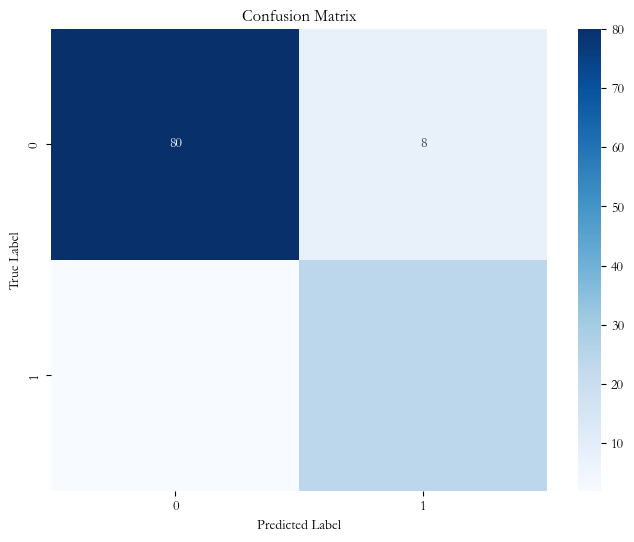

In [44]:
# AUC et courbe ROC

from sklearn.metrics import confusion_matrix

# Create the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
 
# Create a confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues') #, xticklabels=data.target_names, yticklabels=data.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

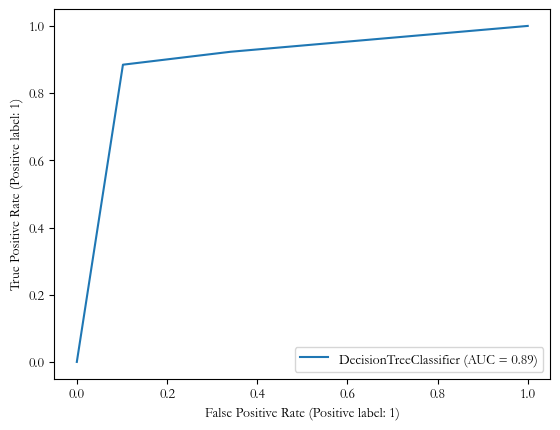

In [45]:
# AUC

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(dt, X_test, y_test)
#display.plot()
plt.show()

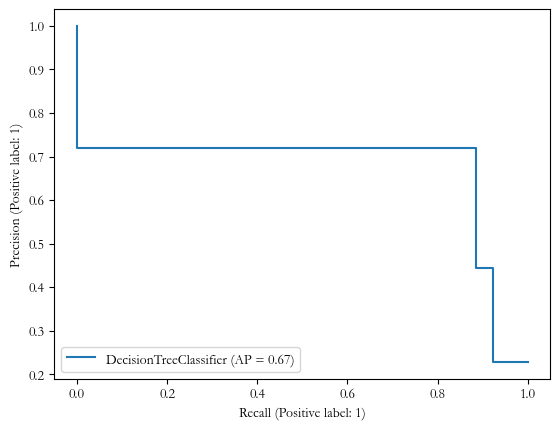

In [49]:
# Courbe Precision - Recall

from sklearn.metrics import PrecisionRecallDisplay

#y_true = np.array([0, 0, 1, 1])
#>>> y_scores = np.array([0.1, 0.4, 0.35, 0.8])
PrecisionRecallDisplay.from_estimator(dt, X_test, y_test)


In [52]:
from sklearn.metrics import average_precision_score
auc_pr = average_precision_score(y_true=y_test, y_score=y_pred)
print("AUC PR: ", 100*round(auc_pr,2)," %")

AUC PR:  71.0  %
